In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [2]:
# Load data and the corresponding kernel
data = np.load('data/data-128.npy')
kernel = np.load('kernel/kernel-128.npy')
print(data.shape, kernel.shape)

(804,) (804, 256)


In [3]:
data = np.reshape(data, (1, 804))
def nor_data(data):
    return (data - data.min()) / (data.max() - data.min())
data = nor_data(data)

In [4]:
model = tf.keras.Sequential([
  Dense(1024, activation=tf.nn.relu, input_shape=(804,)), 
  # Dropout(0.25),
  # BatchNormalization(),
  Dense(512),
  LeakyReLU(),
  # Dropout(0.25),
  # BatchNormalization(),
  Dense(512),
  LeakyReLU(),
  # Dropout(0.25),
  # BatchNormalization(),
  # Dense(512, activation=LeakyReLU, use_bias=True),
  
  
  Dense(256)
])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-09-29 22:47:45.674752: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-29 22:47:45.674909: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
def tfnor_data(data):
    return (data - tf.reduce_min(data)) / (tf.reduce_max(data) - tf.reduce_min(data))
 
def tfnor_recon(data):
    data = data / tf.reduce_max(data)
    data = data - tf.reduce_min(data)
    return data

In [20]:
loss_object = tf.keras.losses.MeanSquaredError()
# loss_object = tf.keras.losses.MeanAbsoluteError()

def loss(model, data, kernel, training):
    recon = model(data, training=training)
    recon = tfnor_recon(recon)
    # print(recon.shape)
    recon = tf.reshape(recon, [256])
    # print(recon.shape)
    data_model = tf.tensordot(kernel, recon, axes=1)
    data_model = tfnor_data(data_model)
    # print(data_model.shape)
    return loss_object(data, data_model)

In [7]:
l = loss(model, data, kernel, training=False)
print("Loss test: {}".format(l))

Loss test: 0.3177410960197449


In [21]:
def grad(model, data, kernel):
  with tf.GradientTape() as tape:
    loss_value = loss(model, data, kernel, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [9]:
loss_value, grads = grad(model, data, kernel)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, data, kernel, training=True).numpy()))

Step: 0, Initial Loss: 0.3177410960197449
Step: 1,         Loss: 0.2769112288951874


In [22]:
train_loss_results = []
num_epochs = 2001
for epoch in range(num_epochs):
  loss_value, grads = grad(model, data, kernel)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  train_loss_results.append(loss_value)
  if epoch % 50 == 0:
    print("Epoch {:04d}: Loss: {:.5f}".format(epoch, loss_value))
                        

Epoch 0000: Loss: 0.00018
Epoch 0050: Loss: 0.00035
Epoch 0100: Loss: 0.00158
Epoch 0150: Loss: 0.00045
Epoch 0200: Loss: 0.00023
Epoch 0250: Loss: 0.00016
Epoch 0300: Loss: 0.00016
Epoch 0350: Loss: 0.00015
Epoch 0400: Loss: 0.00015
Epoch 0450: Loss: 0.00015
Epoch 0500: Loss: 0.00015
Epoch 0550: Loss: 0.00015
Epoch 0600: Loss: 0.00015
Epoch 0650: Loss: 0.00015
Epoch 0700: Loss: 0.00015
Epoch 0750: Loss: 0.00015
Epoch 0800: Loss: 0.00015
Epoch 0850: Loss: 0.00015
Epoch 0900: Loss: 0.00015
Epoch 0950: Loss: 0.00015
Epoch 1000: Loss: 0.00015
Epoch 1050: Loss: 0.00015
Epoch 1100: Loss: 0.00015
Epoch 1150: Loss: 0.00015
Epoch 1200: Loss: 0.00015
Epoch 1250: Loss: 0.00015
Epoch 1300: Loss: 0.00016
Epoch 1350: Loss: 0.00015
Epoch 1400: Loss: 0.00015
Epoch 1450: Loss: 0.00015
Epoch 1500: Loss: 0.00015
Epoch 1550: Loss: 0.00015
Epoch 1600: Loss: 0.00015
Epoch 1650: Loss: 0.00016
Epoch 1700: Loss: 0.00016
Epoch 1750: Loss: 0.00015
Epoch 1800: Loss: 0.00015
Epoch 1850: Loss: 0.00016
Epoch 1900: 

In [26]:
sig_dnn = model(data)
sig_dnn = tfnor_recon(sig_dnn)
sig_dnn = np.reshape(sig_dnn,(256))


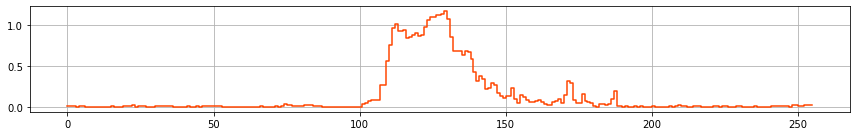

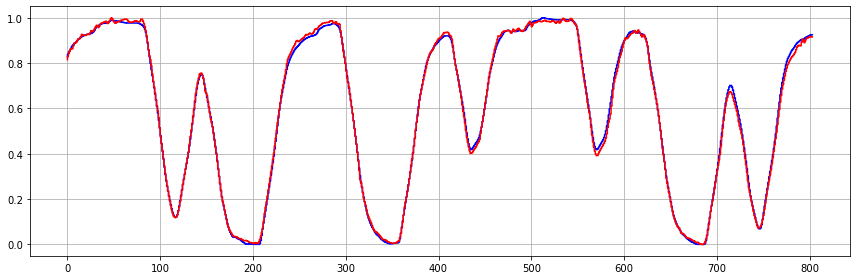

In [44]:
test_dnn = nor_data(np.dot(kernel, sig_dnn))
test_dnn.shape

plt.figure(figsize=[12, 2])
plt.step(np.arange(sig_dnn.size), sig_dnn[::-1], color='orangered')
plt.grid(True)
plt.tight_layout()
plt.show()
data_tmp = np.reshape(data, (804))
plt.figure(figsize=[12, 4])
plt.step(np.arange(test_dnn.size), test_dnn, color='blue')
plt.step(np.arange(data_tmp.size), data_tmp, color='red')
plt.grid(True)
plt.tight_layout()
plt.show()


# plt.figure(figsize=[12, 2])

# plt.grid(True)
# plt.tight_layout()
# plt.show()



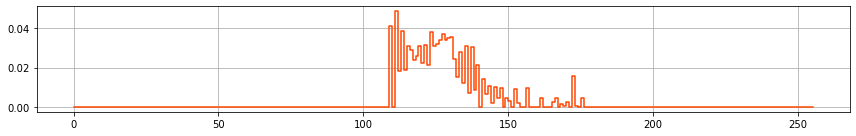

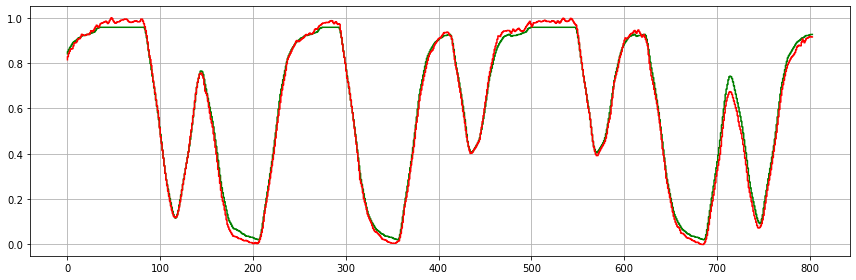

In [48]:
sig_nnls = optimize.nnls(kernel, data.reshape((804)))[0]
# Plot results
plt.figure(figsize=[12, 2])
plt.step(np.arange(sig_nnls.size), sig_nnls[::-1], color='orangered')
plt.grid(True)
plt.tight_layout()
plt.show()
test_nnls = np.dot(kernel, sig_nnls)
test_nnls.shape
plt.figure(figsize=[12, 4])
plt.step(np.arange(test_nnls.size), test_nnls, color='green')
plt.step(np.arange(data_tmp.size), data_tmp, color='red')
plt.grid(True)
plt.tight_layout()
plt.show()


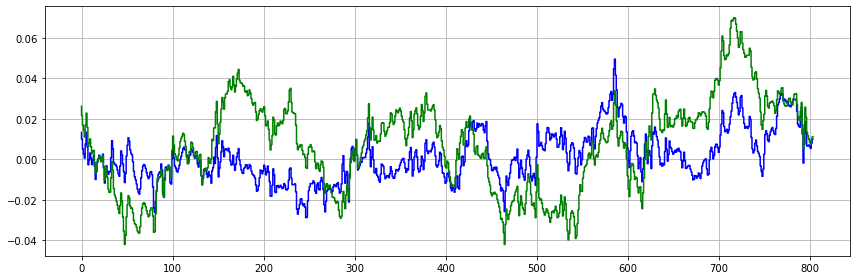

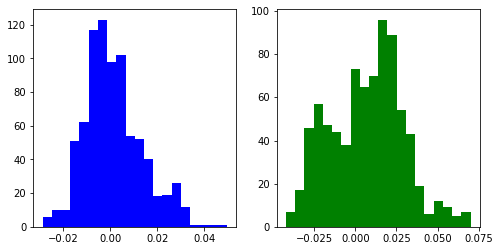

In [49]:
plt.figure(figsize=[12, 4])
plt.step(np.arange(test_dnn.size), test_dnn-data_tmp, color='blue')
plt.step(np.arange(test_dnn.size), test_nnls-data_tmp, color='green')
plt.grid(True)
plt.tight_layout()
plt.show()
# print(test_dnn-data_tmp)
plt.figure(figsize=[8, 4])
plt.subplot(121)
plt.hist(test_dnn-data_tmp, 20, facecolor='blue')
plt.subplot(122)
plt.hist(test_nnls-data_tmp, 20, facecolor='green')
plt.show()


In [8]:
class Model1d(Model):

  def __init__(self):
    super().__init__()
    self.dense1 = layers.Dense(1024, activation=tf.nn.relu)
    self.dense2 = layers.Dense(512, activation=tf.nn.relu)
    self.dense3 = layers.Dense(256)
    self.dropout = layers.Dropout(0.25)

  def call(self, inputs):
    x = self.dense1(inputs)
    x = self.dense2(x)
    return self.dense3(x)

model = Model1d()
    
    

In [ ]:
def foward_model(recon, kernel):
    return tf.multiply(recon, kernel)
class Rec1d():
    def __init__(self, input_data, input_kernel):
        self.input_data = input_data
        self.input_kernel = input_kernel
    
    def make_model(self):
        self.recon_model = Model1d()
        self.model_optimizer = tf.
        self.model_optimizer = tf.keras.optimizers.Adam(self.g_learning_rate)

        
        
               
    def make_chechpoints(self):
        checkpoint_dir = '/data/ganrec/training_checkpoints'
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                         discriminator_optimizer=self.discriminator_optimizer,
                                         generator=self.generator,
                                         discriminator=self.discriminator)

    @tf.function
    def train_step(self):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            recon = self.recon_model(self.input_data)
            model_input = foward_model(recon, self.input_kernel)

            real_output = self.discriminator(image_y, training=True)
            fake_output = self.discriminator(recon, training=True)
            g_loss = generator_loss(fake_output, image_y, recon, self.l1_ratio)
            d_loss = discriminator_loss(real_output, fake_output)
        gradients_of_generator = gen_tape.gradient(g_loss,
                                                   self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(d_loss,
                                                        self.discriminator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(gradients_of_generator,
                                                     self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,
                                                         self.discriminator.trainable_variables))
        return {'recon': recon,
                'g_loss': g_loss,
                'd_loss': d_loss}

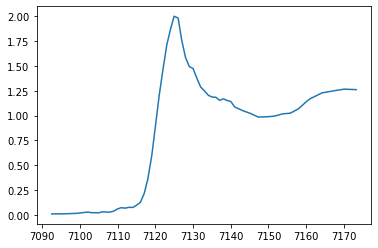

In [5]:
plt.plot(energy, data[:,50,50])

In [5]:
len(energy)

57

In [6]:
ref = np.loadtxt('/Users/xiaogangyang/Downloads/test_data/test_ref_athena.nor')

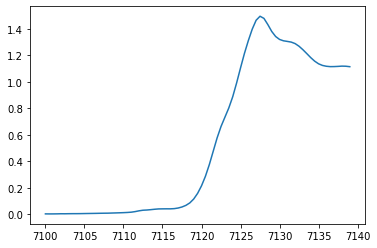

In [9]:
plt.plot(ref[:,0], ref[:,3])

In [10]:
energy_normalizer = layers.Normalization(input_shape=[1,], axis=None)
energy_normalizer.adapt(energy)

2022-07-21 14:44:57.982075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-21 14:44:57.999219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [11]:
energy_model = tf.keras.Sequential([
    energy_normalizer,
    layers.Dense(units=1)
])

energy_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [12]:
energy_model.predict(energy[:10])

2022-07-21 14:45:04.538193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[-2.9277787],
       [-2.654075 ],
       [-2.3931499],
       [-2.1584117],
       [-2.088934 ],
       [-2.0034137],
       [-1.9280379],
       [-1.8419673],
       [-1.7635247],
       [-1.6863794]], dtype=float32)

In [13]:
energy_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_absolute_error')

In [14]:
%%time
history = energy_model.fit(
    energy,
    data[:,50,50],
    epochs=100,
    verbose=0,
    validation_split=0.2
)

2022-07-21 14:45:10.841868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-21 14:45:11.798513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


CPU times: user 2.03 s, sys: 809 ms, total: 2.84 s
Wall time: 3.22 s


In [15]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.339748,0.927008,95
96,0.338620,0.925960,96
97,0.342325,0.902651,97
98,0.336791,0.885788,98
99,0.342308,0.877323,99


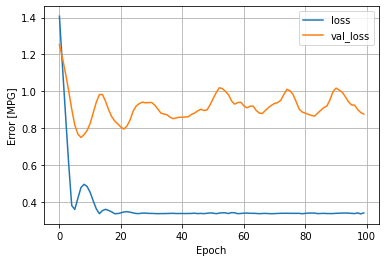

In [16]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  # plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
plot_loss(history)

In [17]:
test_results = {}

test_results['energy_model'] = energy_model.evaluate(
    energy,
    data[:,51, 51], verbose=0)

In [18]:
x = energy
y = energy_model.predict(x)

2022-07-21 14:45:26.857900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


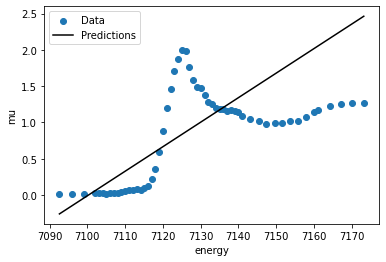

In [19]:
def plot_energy(x, y):
  plt.scatter(energy, data[:, 50, 50], label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('energy')
  plt.ylabel('mu')
  plt.legend()
plot_energy(x, y)

In [20]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, activation='relu'),
      layers.Dense(128, activation='relu'),
      # layers.Dense(64, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [21]:
dnn_energy_model = build_and_compile_model(energy_normalizer)
dnn_energy_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_1 (Dense)             (None, 128)               256       
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 50,052
Trainable params: 50,049
Non-trainable params: 3
__________________________________________________

In [22]:
%%time
history = dnn_energy_model.fit(
    energy,
    data[:,50,50],
    validation_split=0.2,

    verbose=0, epochs=200)

2022-07-21 14:45:47.980346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-21 14:45:49.558528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


CPU times: user 4.6 s, sys: 1.77 s, total: 6.37 s
Wall time: 7.13 s


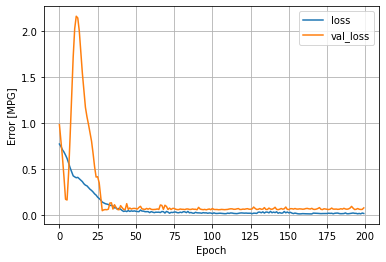

In [23]:
plot_loss(history)

In [24]:
x = energy
y = dnn_energy_model.predict(x)

2022-07-21 14:46:00.824175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


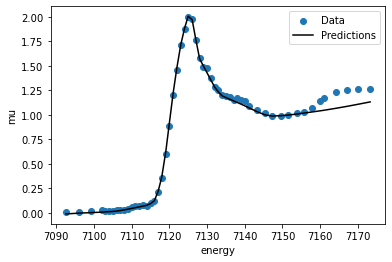

In [25]:
plot_energy(x, y)

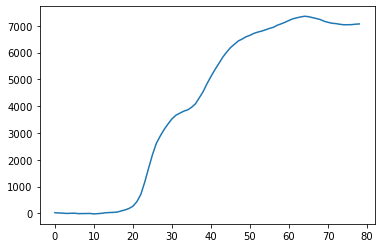

In [27]:
ref_1 = ref[:,:2]
a = ref_1[:,1]*ref_1[:,0]
plt.plot(a)

In [28]:
%%time
history = dnn_energy_model.fit(
    ref_1[:,0],
    ref_1[:,1],
    validation_split=0.2,
    verbose=0, epochs=200)

CPU times: user 4.14 s, sys: 1.62 s, total: 5.77 s
Wall time: 5.02 s


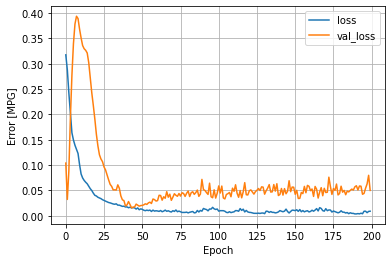

In [29]:
plot_loss(history)

In [30]:
x = energy
y = dnn_energy_model.predict(x)

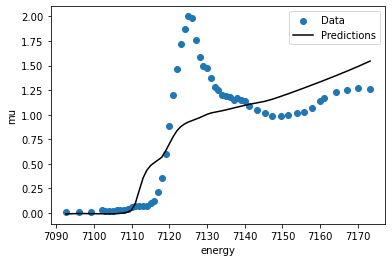

In [31]:
plot_energy(x, y)

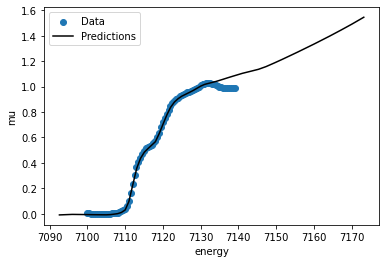

In [32]:
def plot_energy(x, y):
  plt.scatter(ref_1[:,0], ref_1[:, 1], label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('energy')
  plt.ylabel('mu')
  plt.legend()
plot_energy(x, y)